# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

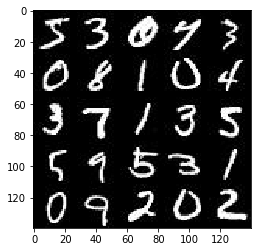

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import helper
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

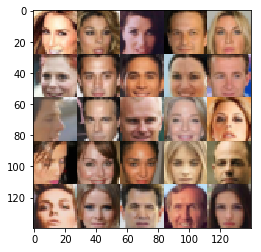

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/xigu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(stddev=0.02)
    alpha=0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(stddev=0.02)
    alpha=0.1
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out      



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    print_every=10
    show_every=100
    steps = 0    
      
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.8719
Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 2.5502
Epoch 1/2... Discriminator Loss: 0.4203... Generator Loss: 2.9988
Epoch 1/2... Discriminator Loss: 0.4215... Generator Loss: 3.3475
Epoch 1/2... Discriminator Loss: 0.3786... Generator Loss: 3.7614
Epoch 1/2... Discriminator Loss: 0.4187... Generator Loss: 3.2140
Epoch 1/2... Discriminator Loss: 0.3654... Generator Loss: 4.0355
Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 4.3443
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 4.8479


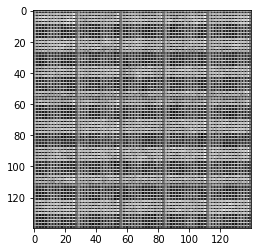

Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 4.3066
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 4.1425
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 5.3076
Epoch 1/2... Discriminator Loss: 0.4677... Generator Loss: 3.7300
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 4.5920
Epoch 1/2... Discriminator Loss: 0.3565... Generator Loss: 5.4618
Epoch 1/2... Discriminator Loss: 0.3565... Generator Loss: 4.4746
Epoch 1/2... Discriminator Loss: 0.3477... Generator Loss: 4.5030
Epoch 1/2... Discriminator Loss: 0.3598... Generator Loss: 4.3622
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 4.4251


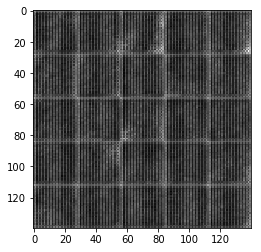

Epoch 1/2... Discriminator Loss: 0.4708... Generator Loss: 3.6481
Epoch 1/2... Discriminator Loss: 0.3858... Generator Loss: 5.0772
Epoch 1/2... Discriminator Loss: 0.3715... Generator Loss: 3.9719
Epoch 1/2... Discriminator Loss: 0.4417... Generator Loss: 3.0817
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 4.0329
Epoch 1/2... Discriminator Loss: 0.4043... Generator Loss: 3.6117
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 2.2898
Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 2.7162
Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.5069


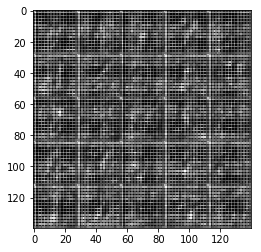

Epoch 1/2... Discriminator Loss: 0.4657... Generator Loss: 3.4431
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 2.0389
Epoch 1/2... Discriminator Loss: 1.7690... Generator Loss: 0.4411
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 3.5692
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.1563
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 2.9523
Epoch 1/2... Discriminator Loss: 2.0097... Generator Loss: 0.3116
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 0.9810
Epoch 1/2... Discriminator Loss: 0.5091... Generator Loss: 2.3751
Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 2.9789


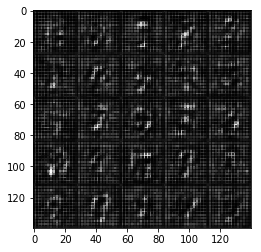

Epoch 1/2... Discriminator Loss: 0.6248... Generator Loss: 3.0358
Epoch 1/2... Discriminator Loss: 0.6607... Generator Loss: 1.7538
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 2.2910
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 1.6433
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 1.5245
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 2.5555
Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 2.1060
Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.9788
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.6823


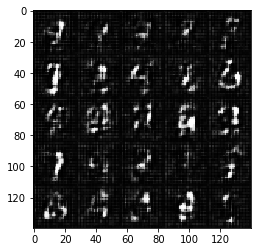

Epoch 1/2... Discriminator Loss: 0.5455... Generator Loss: 2.0454
Epoch 1/2... Discriminator Loss: 0.5421... Generator Loss: 2.3431
Epoch 1/2... Discriminator Loss: 0.6260... Generator Loss: 1.6923
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 2.0713
Epoch 1/2... Discriminator Loss: 0.6690... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 0.6200... Generator Loss: 1.9682
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 2.6518
Epoch 1/2... Discriminator Loss: 0.6587... Generator Loss: 1.8342
Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 1.8067
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 1.6875


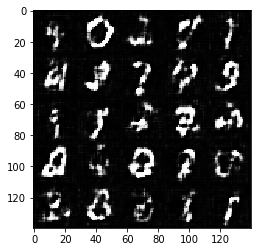

Epoch 1/2... Discriminator Loss: 0.5874... Generator Loss: 2.0305
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 1.6292
Epoch 1/2... Discriminator Loss: 0.7131... Generator Loss: 1.7830
Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 2.7747
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.3487
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.3808
Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 1.1072
Epoch 1/2... Discriminator Loss: 0.6498... Generator Loss: 1.9913
Epoch 1/2... Discriminator Loss: 0.6885... Generator Loss: 1.5096


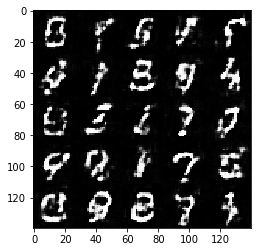

Epoch 1/2... Discriminator Loss: 0.6614... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.1935
Epoch 1/2... Discriminator Loss: 0.8616... Generator Loss: 1.1054
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.2013
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 1.2355
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 2.5343
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 0.9276
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 1.4466


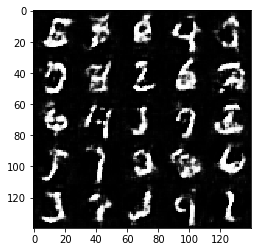

Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 1.6182
Epoch 1/2... Discriminator Loss: 0.6509... Generator Loss: 1.7686
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.9192
Epoch 1/2... Discriminator Loss: 0.6769... Generator Loss: 1.6655
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.5984
Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 1.3857
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 2.1537
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 1.6969
Epoch 1/2... Discriminator Loss: 0.7985... Generator Loss: 1.2683


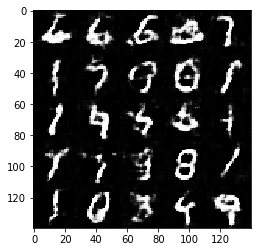

Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.4979
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 1.9375
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.4247
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.4661
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 2.3074
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.2115
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.5066


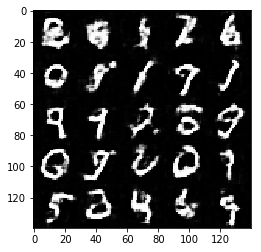

Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 1.2063
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.2675
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.3305
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.5743
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.4114
Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 0.8139
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 1.7959
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.2997


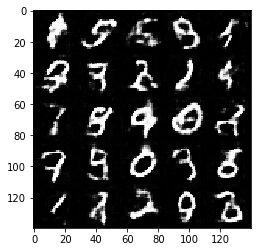

Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.4901
Epoch 2/2... Discriminator Loss: 1.0374... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.3202
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.6837
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.7321
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.9041
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.0959
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.4552
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 1.7605
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 1.5462


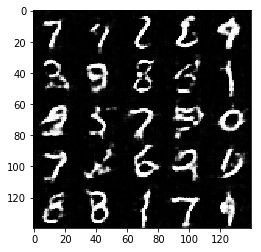

Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 2.4165
Epoch 2/2... Discriminator Loss: 0.8737... Generator Loss: 1.9535
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 1.6969
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 2.2537
Epoch 2/2... Discriminator Loss: 0.7907... Generator Loss: 1.7121
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.4798
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 2.1123
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.2701
Epoch 2/2... Discriminator Loss: 0.9299... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.7557


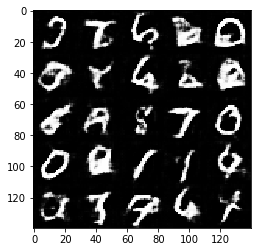

Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 1.0812
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 2.0013
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 1.2295
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.6740
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.3201
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 2.1557
Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 1.4464
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 2.1648


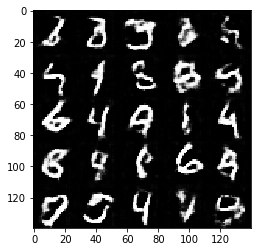

Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 0.6780... Generator Loss: 2.0091
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 2.3236
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 0.8603
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 1.7154
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.1963
Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 1.5407
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.6608
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 2.0534


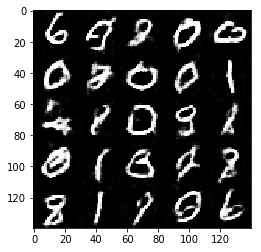

Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.5279
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 1.1542
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.0145
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.5803
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 2.3059
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 1.0875
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.4509
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 2.1189
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 0.7199... Generator Loss: 1.5557


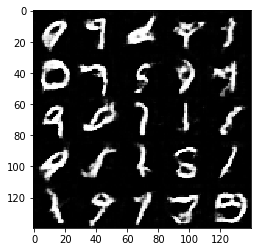

Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 1.3569
Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.9328
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 0.9802
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.7127
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 0.9204
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.5607
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.7948
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 0.7737... Generator Loss: 1.5686


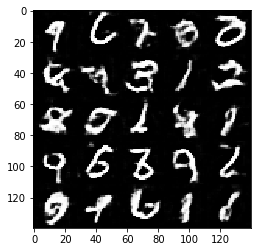

Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.5454
Epoch 2/2... Discriminator Loss: 0.7141... Generator Loss: 1.6581
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 1.8207
Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 1.3521
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.4793
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 1.4495
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.8049
Epoch 2/2... Discriminator Loss: 0.8172... Generator Loss: 1.1910


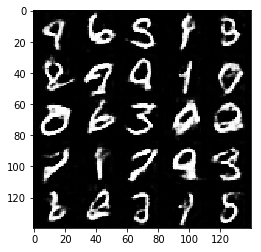

Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.0546
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.9929
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 2.0555
Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 1.6001
Epoch 2/2... Discriminator Loss: 0.8440... Generator Loss: 1.9242
Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 1.5334
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 2.1721


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1206... Generator Loss: 0.0934
Epoch 1/1... Discriminator Loss: 2.0933... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 2.4191
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 4.7863
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 2.8649
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 5.8603
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 4.0464
Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.7341


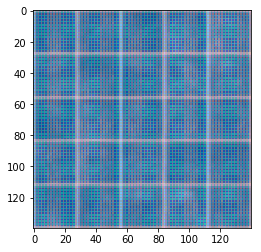

Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.5741
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.6414
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 2.8698
Epoch 1/1... Discriminator Loss: 3.1414... Generator Loss: 0.0904
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 2.1793
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 3.3787
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 4.6338


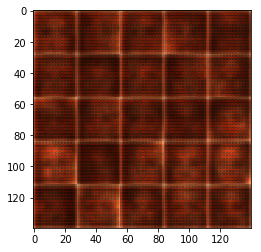

Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 2.2828
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 2.3473... Generator Loss: 0.2034
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 2.4482... Generator Loss: 0.2090
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.5875
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.5845


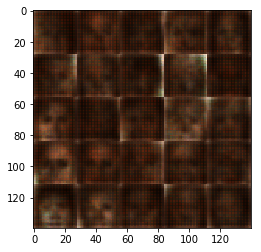

Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.9305
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.8374
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.3896


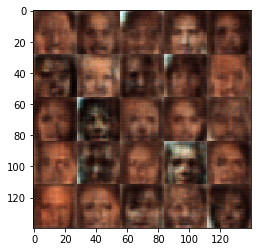

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 2.0168... Generator Loss: 0.3556
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.6614


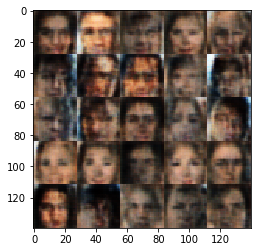

Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.6912... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.5227


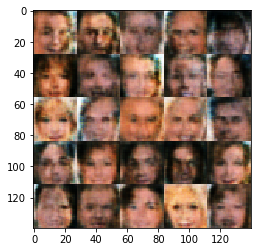

Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.4181


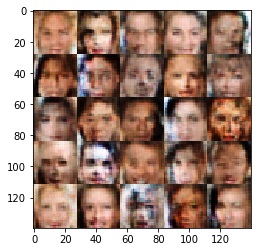

Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6914


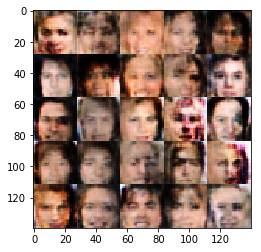

Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7919


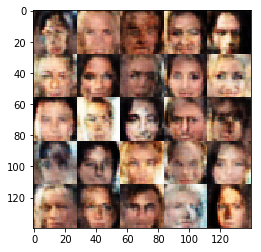

Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.5864
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.1611


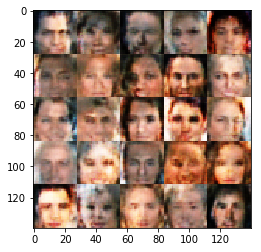

Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.9112


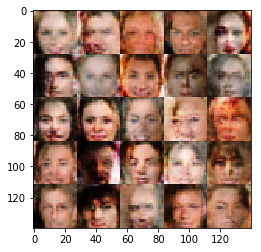

Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.6657


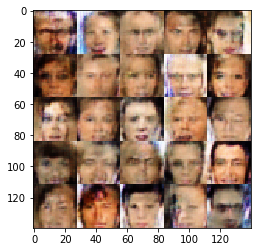

Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.5702
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7635


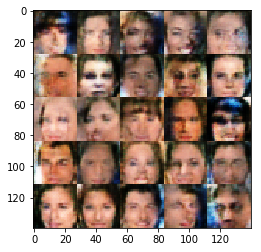

Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.4247
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.9137


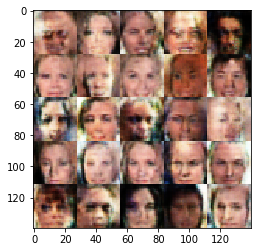

Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.5371


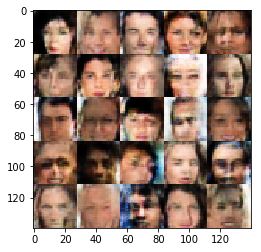

Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7355


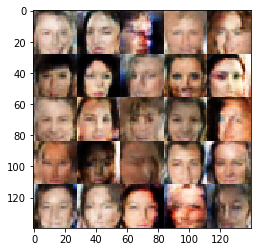

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 0.3122
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9829


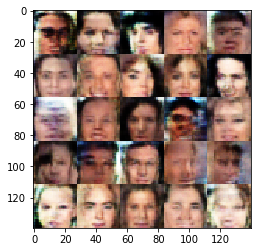

Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.1529


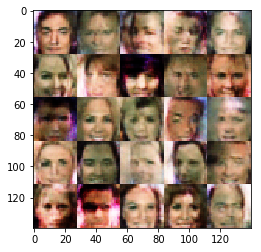

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7499


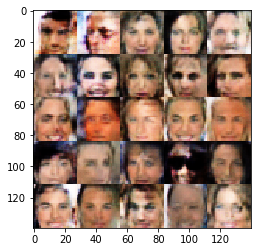

Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.6878... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8644


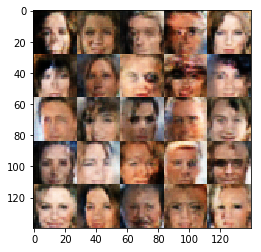

Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6223


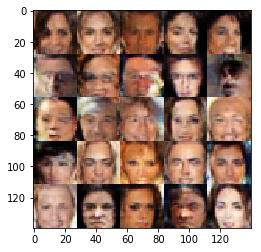

Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.7958... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.9694... Generator Loss: 0.2673
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.6454


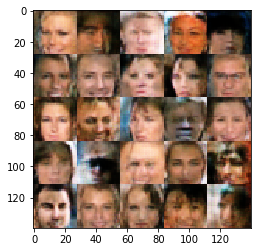

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.7197... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7490


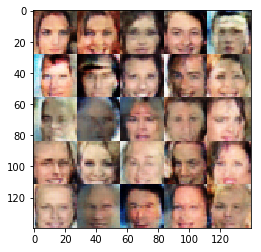

Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.0690


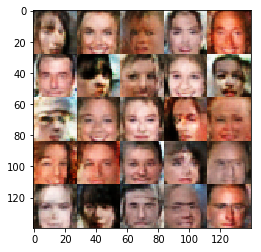

Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.4751


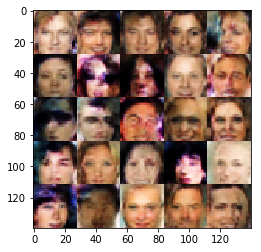

Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.6852


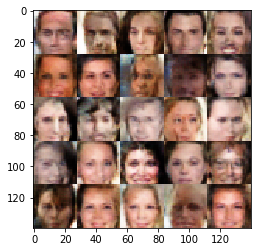

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8354


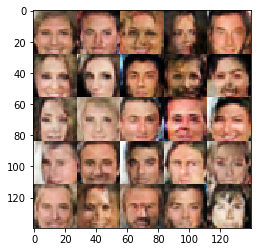

Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.8202... Generator Loss: 0.3255
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.6563... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.4982


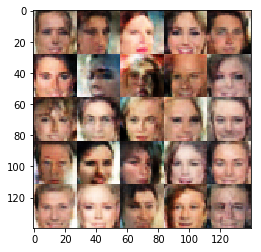

Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6735


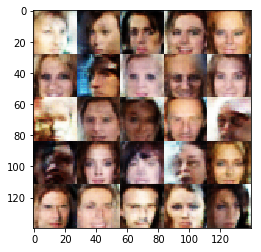

Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.4707


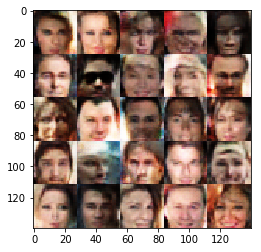

Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.7406... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6227


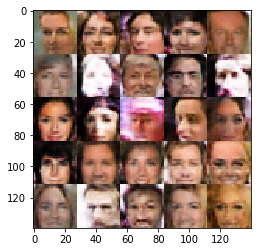

Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7222


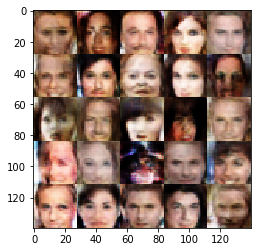

Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.9034... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.5675


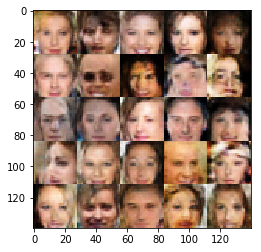

Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.7389... Generator Loss: 0.3198
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6264


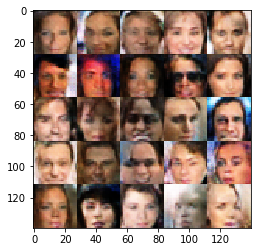

Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 2.0030... Generator Loss: 0.2824
Epoch 1/1... Discriminator Loss: 1.7609... Generator Loss: 0.3514
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.4742


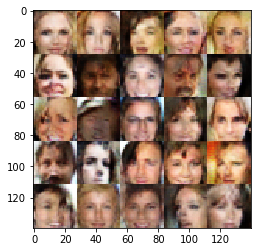

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6382


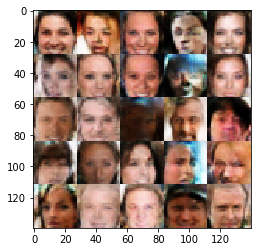

Epoch 1/1... Discriminator Loss: 1.7315... Generator Loss: 0.3312
Epoch 1/1... Discriminator Loss: 1.6393... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.9423


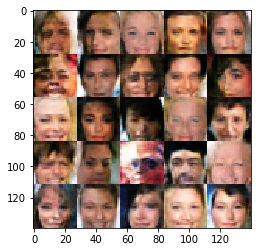

Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.6937... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.4799
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.1854


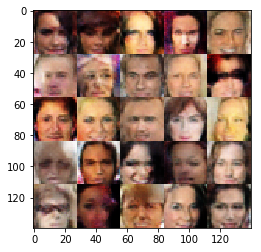

Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7896


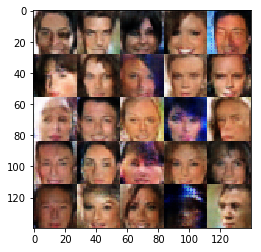

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.7202... Generator Loss: 0.3405
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.4976


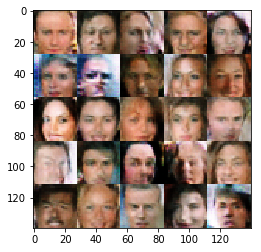

Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.4513
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 2.0129... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.5971


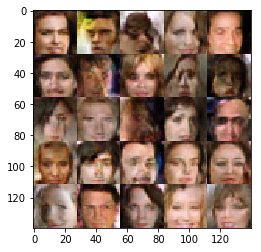

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.8760


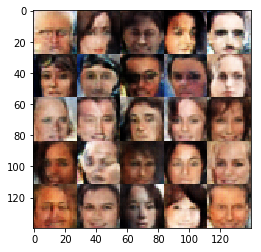

Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7333


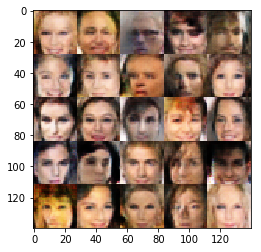

Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.6587... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.5759


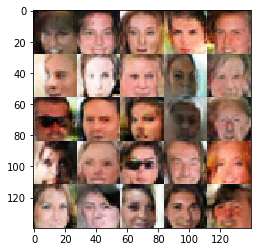

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.8139


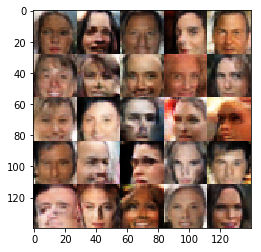

Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5350


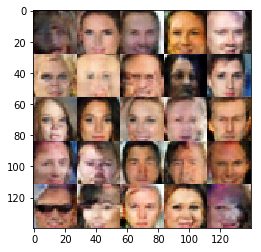

Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.3754
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.7024... Generator Loss: 0.3615


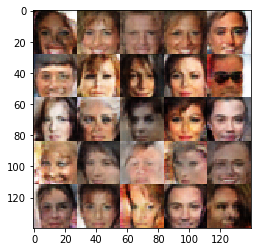

Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.4296
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.9056... Generator Loss: 0.2952
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 2.0484... Generator Loss: 0.2758
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7562


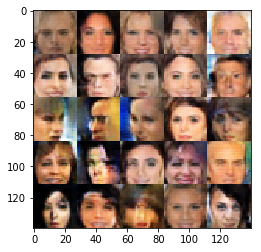

Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 1.0446


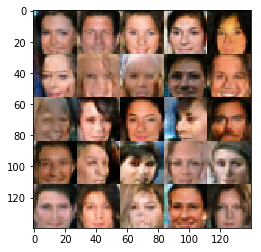

Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7269


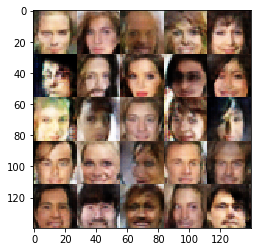

Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.0031


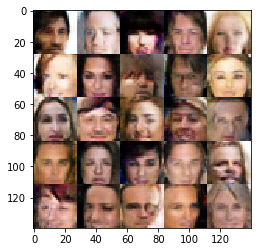

Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.7793... Generator Loss: 0.3608
Epoch 1/1... Discriminator Loss: 1.8025... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.9617


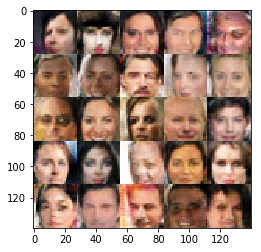

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.9678... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.5301


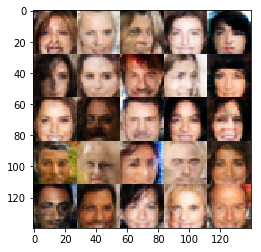

Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.8143... Generator Loss: 0.3122
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.8146


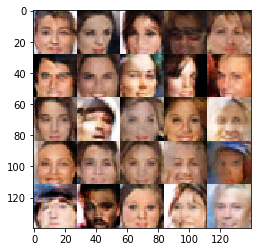

Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.2219
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.4088
Epoch 1/1... Discriminator Loss: 1.9004... Generator Loss: 0.3739
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7050


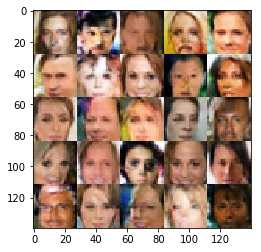

Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4130
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.5607


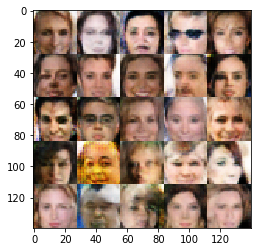

Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.8286... Generator Loss: 0.3009
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7124


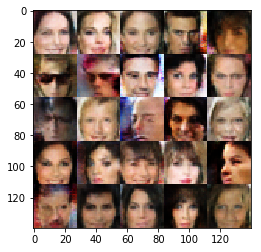

Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.5925


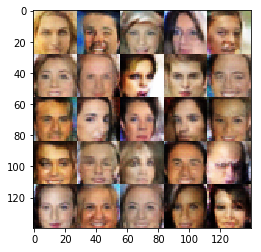

Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4753


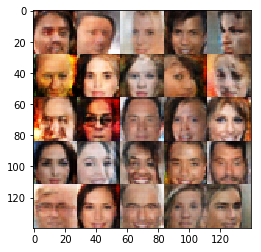

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.9816... Generator Loss: 0.2581
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4322


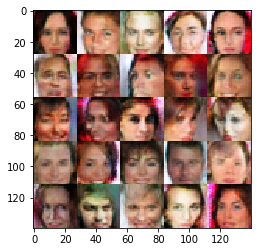

Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 2.1827... Generator Loss: 0.2015
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6653


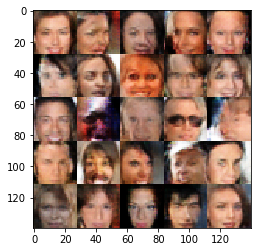

Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 0.3873


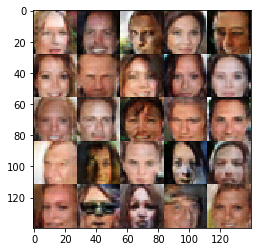

Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.3965


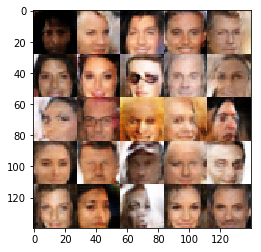

Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.8506... Generator Loss: 0.3035
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7746


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.